<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/data_utils/data_preparation/listings_transformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install ast
import ast
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

  Using cached AST-0.0.2.tar.gz (19 kB)
  Using cached AST-0.0.1.tar.gz (19 kB)
ERROR: Could not find a version that satisfies the requirement ast (from versions: 0.0.1, 0.0.2)
ERROR: No matching distribution found for ast
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
path= ("/content/drive/MyDrive/Colab/airbnb/data/translations/translated_listings.pickle")
listings = pd.read_pickle(path)

In [19]:
# transform price
listings["price"] = (
    listings["price"].str.replace("$", "").str.replace(",", "").astype(float)
)

In [20]:
#remove zeros
print(len(listings[listings["price"] == 0]))
listings = listings[listings["price"] != 0]

5


In [21]:
# log price
listings["log_price"] = np.log(listings["price"])

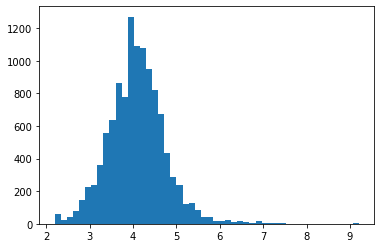

In [22]:
import matplotlib.pyplot as plt
plt.hist(listings["log_price"], bins=50)
plt.show()

In [23]:
# recode rooms, host_is_superhost and host_identity_verified into dummies
rooms = pd.get_dummies(listings["room_type"], prefix="room")
listings = listings.drop("room_type", axis=1)
listings["host_is_superhost"] = listings["host_is_superhost"].map(dict(t=1, f=0))
listings["instant_bookable"] = listings["instant_bookable"].map(dict(t=1, f=0))
listings["host_identity_verified"] = listings["host_identity_verified"].map(
    dict(t=1, f=0)
)
listings = pd.concat([listings, rooms], axis=1)

In [24]:
# remove columns from listings that do not make sense as predictors

drop_vars = ["name", "listing_url", "scrape_id", "last_scraped", "picture_url", 
       "neighborhood_overview", "description", "host_id", 
       "host_url", "host_name", "host_location", "host_about",
       "host_thumbnail_url", "host_picture_url", "host_neighbourhood", "host_total_listings_count",
       "host_has_profile_pic", "neighbourhood", "neighbourhood_group_cleansed", "bathrooms",
       "maximum_nights", "maximum_nights",	"minimum_minimum_nights", 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated',"has_availability", "calendar_last_scraped",
       "number_of_reviews_ltm", "number_of_reviews_l30d", "license"]

listings = listings.drop(drop_vars, axis=1)

In [25]:
# recode host_verifications into dummies
listings["host_verifications"] = listings["host_verifications"].apply(ast.literal_eval)
host_verifications = listings["host_verifications"]
host_verifications = pd.get_dummies(host_verifications.apply(pd.Series).stack(dropna=False), prefix="host_verification").sum(level=0)
listings = pd.concat([listings, host_verifications], axis=1)
listings = listings.drop("host_verifications", axis=1)

In [26]:
# recode property_type into dummies
properties = pd.get_dummies(listings["property_type"], prefix="property_type")
listings = listings.drop("property_type", axis=1)
listings = pd.concat([listings, properties], axis=1)

In [27]:
# recode neighbourhood_cleansed into dummies
neighbourhood_cleansed = pd.get_dummies(listings["neighbourhood_cleansed"], prefix="neighbourhood_cleansed")
listings = listings.drop("neighbourhood_cleansed", axis=1)
listings = pd.concat([listings, neighbourhood_cleansed], axis=1)

In [28]:
# recode bath into batch shared dummy and number of baths
bath_is_shared = listings["bathrooms_text"].str.contains("shared", case=False, na=False)
bath_is_shared.name = "bath_is_shared"
bath_is_half = listings["bathrooms_text"].str.contains("half", case=False, na=False)
bath_number = listings["bathrooms_text"].str.extract('(\d+\.?\d?)')
bath_number[bath_is_half] = 0.5
bath_number.name = "bath_number"

listings = pd.concat([listings, bath_is_shared, bath_number], axis=1)
listings = listings.drop("bathrooms_text", axis=1)

In [29]:
#@title recode amenities functions
def contains_list(elements, series):
    df = (series == "Not existing value").astype("int")
    for el in elements:
        df = df + series.str.contains(el, case=False, na=0)
    return df
    
def to_binary(series):
  series = (series > 0).astype(int)
  return series

In [118]:
# look at observation with this amenity
listings["amenities"].loc[contains_list(["\"sauna"], listings["amenities"]).astype(bool)].iloc[0]

'["Wine glasses", "Lock on bedroom door", "Safe", "Iron", "Hair dryer", "First aid kit", "Bed linens", "Room-darkening shades", "Paid parking on premises", "TV", "Hangers", "Long term stays allowed", "Crib", "Dedicated workspace", "Host greets you", "Fire extinguisher", "Shower gel", "Carbon monoxide alarm", "Luggage dropoff allowed", "Paid parking off premises", "Smoke alarm", "Wifi", "Elevator", "Microwave", "Laundromat nearby", "Hot water", "Sauna", "Air conditioning", "Refrigerator", "Essentials", "Body soap", "Clothing storage", "Shampoo", "Heating", "Gym", "Dishes and silverware", "Free street parking"]'

In [161]:
# print number of observations with this amenity
np.sum(contains_list(["bathtub"], listings["amenities"]))

5621

In [163]:
#@title recode amenities

# binaries1
tmp_amenities = ["host greets you"]
amenities_greetings = contains_list(tmp_amenities, listings["amenities"])
amenities_greetings.name = "amenities_" + "greetings"
amenities_greetings = to_binary(amenities_greetings)

tmp_amenities = ["building staff"]
amenities_staff = contains_list(tmp_amenities, listings["amenities"])
amenities_staff.name = "amenities_" + "staff"
amenities_staff = to_binary(amenities_staff)

tmp_amenities = ["elevator"]
amenities_elevator = contains_list(tmp_amenities, listings["amenities"])
amenities_elevator.name = "amenities_" + "elevator"
amenities_elevator = to_binary(amenities_elevator)

tmp_amenities = ["Single level home"]
amenities_singlelevel = contains_list(tmp_amenities, listings["amenities"])
amenities_singlelevel.name = "amenities_" + "singlelevel"
amenities_singlelevel = to_binary(amenities_singlelevel)

tmp_amenities = ["keypad"]
amenities_keypad = contains_list(tmp_amenities, listings["amenities"])
amenities_keypad.name = "amenities_" + "keypad"
amenities_keypad = to_binary(amenities_keypad)

tmp_amenities = ["private entrance"]
amenities_privateentrance = contains_list(tmp_amenities, listings["amenities"])
amenities_privateentrance.name = "amenities_" + "privateentrance"
amenities_privateentrance = to_binary(amenities_privateentrance)

tmp_amenities = ["bidet"]
amenities_bidet = contains_list(tmp_amenities, listings["amenities"])
amenities_bidet.name = "amenities_" + "bidet"
amenities_bidet = to_binary(amenities_bidet)

tmp_amenities = ["bathtub"]
amenities_bathtub = contains_list(tmp_amenities, listings["amenities"])
amenities_bathtub.name = "amenities_" + "bathtub"
amenities_bathtub = to_binary(amenities_bathtub)

tmp_amenities = ["fire extinguisher"]
amenities_extinguisher = contains_list(tmp_amenities, listings["amenities"])
amenities_extinguisher.name = "amenities_" + "extinguisher"
amenities_extinguisher = to_binary(amenities_extinguisher)

tmp_amenities = ["dining table"]
amenities_diningtable = contains_list(tmp_amenities, listings["amenities"])
amenities_diningtable.name = "amenities_" + "diningtable"
amenities_diningtable = to_binary(amenities_diningtable)

tmp_amenities = ["smart lock"]
amenities_smartlock = contains_list(tmp_amenities, listings["amenities"])
amenities_smartlock.name = "amenities_" + "smartlock"
amenities_smartlock = to_binary(amenities_smartlock)

tmp_amenities = ["Security cameras on property"]
amenities_cameras = contains_list(tmp_amenities, listings["amenities"])
amenities_cameras.name = "amenities_" + "cameras"
amenities_cameras = to_binary(amenities_cameras)

tmp_amenities = ["tv"]
amenities_tv = contains_list(tmp_amenities, listings["amenities"])
amenities_tv.name = "amenities_" + "tv"
amenities_tv = to_binary(amenities_tv)

tmp_amenities = ["sound system", "record player"]
amenities_sound_system = contains_list(tmp_amenities, listings["amenities"])
amenities_sound_system.name = "amenities_" + "soundsystem"
amenities_sound_system = to_binary(amenities_sound_system)

tmp_amenities = ["AC", "air conditioning"]
amenities_aircon = contains_list(tmp_amenities, listings["amenities"])
amenities_aircon.name = "amenities_" + "aircon"
amenities_aircon = to_binary(amenities_aircon)

tmp_amenities = ["lake", "Waterfront", "Boat slip", "beachfront"]
amenities_water_access = contains_list(tmp_amenities, listings["amenities"])
amenities_water_access.name = "amenities_" + "wateraccess"
amenities_water_access = to_binary(amenities_water_access)

tmp_amenities = ["safe", "lockbox"]
amenities_safe = contains_list(tmp_amenities, listings["amenities"])
amenities_safe.name = "amenities_" + "safe"
amenities_safe = to_binary(amenities_safe)

tmp_amenities = ["piano"]
amenities_piano = contains_list(tmp_amenities, listings["amenities"])
amenities_piano.name = "amenities_" + "piano"
amenities_piano = to_binary(amenities_piano)

tmp_amenities = ["fireplace", "fire pit"]
amenities_fireplace = contains_list(tmp_amenities, listings["amenities"])
amenities_fireplace.name = "amenities_" + "fireplace"
amenities_fireplace = to_binary(amenities_fireplace)

tmp_amenities = ["bio", "ecological", "natur", "fairtrade", "organic"]
amenities_bio = contains_list(tmp_amenities, listings["amenities"])
amenities_bio.name = "amenities_" + "bio"
amenities_bio = to_binary(amenities_bio)

tmp_amenities = ["wifi", "Ethernet connection"]
amenities_wifi = contains_list(tmp_amenities, listings["amenities"])
amenities_wifi.name = "amenities_" + "wifi"
amenities_wifi = to_binary(amenities_wifi)

tmp_amenities = ["balcony"]
amenities_balcony = contains_list(tmp_amenities, listings["amenities"])
amenities_balcony.name = "amenities_" + "balcony"
amenities_balcony = to_binary(amenities_balcony)

tmp_amenities = ["\"Outdoor"]
amenities_outdoor = contains_list(tmp_amenities, listings["amenities"])
amenities_outdoor.name = "amenities_" + "outdoor"
amenities_outdoor = to_binary(amenities_outdoor)

# not sure if this is smart
tmp_amenities = ["smoke_alarm", "monoxide alarm"]
amenities_smoke_alarm = contains_list(tmp_amenities, listings["amenities"])
amenities_smoke_alarm.name = "amenities_" + "smokealarm"
amenities_smoke_alarm = to_binary(amenities_smoke_alarm)

tmp_amenities = ["pets"]
amenities_pets = contains_list(tmp_amenities, listings["amenities"])
amenities_pets.name = "amenities_" + "pets"
amenities_pets = to_binary(amenities_pets)

tmp_amenities = ["iron"]
amenities_iron = contains_list(tmp_amenities, listings["amenities"])
amenities_iron.name = "amenities_" + "iron"
amenities_iron = to_binary(amenities_iron)

tmp_amenities = ["heating"]
amenities_heating = contains_list(tmp_amenities, listings["amenities"])
amenities_heating.name = "amenities_" + "heating"
amenities_heating = to_binary(amenities_heating)

tmp_amenities = ["ev charger"]
amenities_ev_charger = contains_list(tmp_amenities, listings["amenities"])
amenities_ev_charger.name = "amenities_" + "evcharger"
amenities_ev_charger = to_binary(amenities_ev_charger)

tmp_amenities = ["\"gym\"", "Gym in building", "Shared gym"]
amenities_gym = contains_list(tmp_amenities, listings["amenities"])
amenities_gym.name = "amenities_" + "gym"
amenities_gym = to_binary(amenities_gym)

tmp_amenities = ["Baby monitor", "baby safety gates", "baby bath", 
                 "Babysitter recommendations", "Changing table", 
                 "crib", "high chair", "Outlet covers"]
amenities_baby = contains_list(tmp_amenities, listings["amenities"])
amenities_baby.name = "amenities_" + "baby"
amenities_baby = to_binary(amenities_baby)

tmp_amenities = ["Beach essentials", "Barbecue utensils", "Bikes", "Board games", "toys", "game console",
                 "ping pong", "Pool table", "bbq grill"]
amenities_games = contains_list(tmp_amenities, listings["amenities"])
amenities_games.name = "amenities_" + "games"
amenities_games = to_binary(amenities_games)

# binaries2
tmp_amenities = ["\"washer"]
amenities_washer = contains_list(tmp_amenities, listings["amenities"])
amenities_washer.name = "amenities_" + "washer"
amenities_washer = to_binary(amenities_washer)

tmp_amenities = ["Free washer"]
amenities_freewasher = contains_list(tmp_amenities, listings["amenities"])
amenities_freewasher.name = "amenities_" + "freewasher"
amenities_freewasher = to_binary(amenities_freewasher)

tmp_amenities = ["Paid washer"]
amenities_paidwasher = contains_list(tmp_amenities, listings["amenities"])
amenities_paidwasher.name = "amenities_" + "paidwasher"
amenities_paidwasher = to_binary(amenities_paidwasher)

tmp_amenities = ["\"dryer"]
amenities_dryer = contains_list(tmp_amenities, listings["amenities"])
amenities_dryer.name = "amenities_" + "dryer"
amenities_dryer = to_binary(amenities_dryer)

tmp_amenities = ["Free dryer"]
amenities_freedryer = contains_list(tmp_amenities, listings["amenities"])
amenities_freedryer.name = "amenities_" + "freedryer"
amenities_freedryer = to_binary(amenities_freedryer)

tmp_amenities = ["Paid dryer"]
amenities_paiddryer = contains_list(tmp_amenities, listings["amenities"])
amenities_paiddryer.name = "amenities_" + "paiddryer"
amenities_paiddryer = to_binary(amenities_paiddryer)

tmp_amenities = ["Private fenced garden or backyard", "Private garden or backyard"]
amenities_privategarden = contains_list(tmp_amenities, listings["amenities"])
amenities_privategarden.name = "amenities_" + "privategarden"
amenities_privategarden = to_binary(amenities_privategarden)

tmp_amenities = ["Shared fenced garden or backyard", "Shared garden or backyard"]
amenities_sharedgarden = contains_list(tmp_amenities, listings["amenities"])
amenities_sharedgarden.name = "amenities_" + "sharedgarden"
amenities_sharedgarden = to_binary(amenities_sharedgarden)

tmp_amenities = ["free carport, free driveway, free parking, free residential"]
amenities_free_parking = contains_list(tmp_amenities, listings["amenities"])
amenities_free_parking.name = "amenities_" + "freeparking"
amenities_free_parking = to_binary(amenities_free_parking)

tmp_amenities = ["paid parking, paid street"]
amenities_paid_parking = contains_list(tmp_amenities, listings["amenities"])
amenities_paid_parking.name = "amenities_" + "paidparking"
amenities_paid_parking = to_binary(amenities_paid_parking)

tmp_amenities = ["\"hot tub", "\"sauna"]
amenities_spa = contains_list(tmp_amenities, listings["amenities"])
amenities_spa.name = "amenities_" + "spa"
amenities_spa = to_binary(amenities_spa)

tmp_amenities = ["shared hot tub", "shared sauna"]
amenities_sharedspa = contains_list(tmp_amenities, listings["amenities"])
amenities_sharedspa.name = "amenities_" + "sharedspa"
amenities_sharedspa = to_binary(amenities_sharedspa)

tmp_amenities = ["private hot tub", "private sauna"]
amenities_privatespa = contains_list(tmp_amenities, listings["amenities"])
amenities_privatespa.name = "amenities_" + "privatespa"
amenities_privatespa = to_binary(amenities_privatespa)

tmp_amenities = ["\"pool\"", "indoor heated pool"]
amenities_pool = contains_list(tmp_amenities, listings["amenities"])
amenities_pool.name = "amenities_" + "pool"
amenities_pool = to_binary(amenities_pool)

tmp_amenities = ["Shared outdoor infinity rooftop pool", "Shared outdoor pool",
                 "Shared outdoor rooftop pool", "Shared pool"]
amenities_sharedpool = contains_list(tmp_amenities, listings["amenities"])
amenities_sharedpool.name = "amenities_" + "sharedpool"
amenities_sharedpool = to_binary(amenities_sharedpool)

tmp_amenities = ["private pool"]
amenities_privatepool = contains_list(tmp_amenities, listings["amenities"])
amenities_privatepool.name = "amenities_" + "privatepool"
amenities_privatepool = to_binary(amenities_privatepool)

# non-binaries
bath_amenities = ["soap", "conditioner", "shampoo", "shower gel", "bathroom essentials"]
amenities_nbath = contains_list(bath_amenities, listings["amenities"])
amenities_nbath.name = "amenities_" + "nbath"

tv_extras_amenities = ["premium", "amazon", "apple tv", "netflix", "HBO"]
amenities_tv_extras = contains_list(tv_extras_amenities, listings["amenities"])
amenities_tv_extras.name = "amenities_" + "tv_extras"

tmp_amenities = ["workspace", "office chair", "monitor"]
amenities_workspace = contains_list(tmp_amenities, listings["amenities"])
amenities_workspace.name = "amenities_" + "workspace"

tmp_amenities = ["clothing storage", "walk-in closet", "dresser", "wardrobe", "closet"]
amenities_clothingstrg = contains_list(tmp_amenities, listings["amenities"])
amenities_clothingstrg.name = "amenities_" + "clothingstrg"

amenities_wifi_speed = listings["amenities"].str.extract("(\d+)[^\d]+Mbps")[0].fillna(16).astype(int)
amenities_wifi_speed.name = "amenities_wifi_speed"

# not so sure if this is so smart maybe big guys like fridge as binary dunno
kitchen_amenities = ["stove", "oven", "refrigerator|fridge", "toaster", "rice maker", "kitchen",
                     "Coffee maker|coffee machine|nespresso machine", "Bread maker", "baking sheet", 
                     "dishwasher", "freezer", "kettle", "cooking basics", "dinnerware", "Dishes and silverware", 
                     "trash compactor", "microwave"]
amenities_nkitchen = contains_list(kitchen_amenities, listings["amenities"])
amenities_nkitchen.name = "amenities_" + "nkitchen"

In [164]:
amenity_categories = [amenities_greetings, amenities_staff, amenities_elevator, amenities_singlelevel, amenities_keypad, amenities_privateentrance, amenities_bidet,
                      amenities_bathtub, amenities_extinguisher, amenities_diningtable, amenities_smartlock, amenities_cameras, amenities_tv, amenities_sound_system,
                      amenities_aircon, amenities_water_access, amenities_safe, amenities_piano, amenities_fireplace, amenities_bio, amenities_wifi, amenities_balcony,
                      amenities_outdoor, amenities_smoke_alarm, amenities_pets, amenities_iron, amenities_heating, amenities_ev_charger, amenities_gym, amenities_baby,
                      amenities_games, amenities_washer, amenities_freewasher, amenities_paidwasher, amenities_dryer, amenities_freedryer, amenities_paiddryer,
                      amenities_privategarden, amenities_sharedgarden, amenities_free_parking, amenities_paid_parking, amenities_spa, amenities_sharedspa, amenities_privatespa,
                      amenities_pool, amenities_sharedpool, amenities_privatepool, amenities_nbath, amenities_tv_extras, amenities_workspace, amenities_clothingstrg,
                      amenities_nkitchen, amenities_wifi_speed]

listings = pd.concat([listings, *amenity_categories], axis=1)
# todo amenities noch droppen

53

In [ ]:
listings

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,description_en,host_about_en,name_en,...,neighbourhood_cleansed_Margareten,neighbourhood_cleansed_Mariahilf,neighbourhood_cleansed_Meidling,neighbourhood_cleansed_Neubau,neighbourhood_cleansed_Ottakring,neighbourhood_cleansed_Penzing,neighbourhood_cleansed_Rudolfsheim-Fnfhaus,neighbourhood_cleansed_Simmering,neighbourhood_cleansed_Wieden,neighbourhood_cleansed_Whring,bath_is_shared,0,amenities_nkitchen,amenities_nbath,amenities_tv,amenities_tv_extras,amenities_sound_system,amenities_aircon,amenities_washer,amenities_smoke_alarm,amenities_outdoor,amenities_water_access,amenities_gym,amenities_pool,amenities_,amenities_safe,amenities_piano,amenities_pets,amenities_paid_parking,amenities_free_parking,amenities_iron,amenities_fireplace,amenities_workspace,amenities_clothingstrg,amenities_wifi,amenities_ev_charger,amenities_wifi_speed,amenities_games,amenities_baby,amenities_baby
5339,28040371,2017-08-14,NaN,NaN,NaN,0.0,1.0,1.0,48.175930,16.282230,5,2.0,3.0,"[""Hair dryer"", ""Keypad"", ""Cooking basics"", ""TV...",96.0,2,2,23,44,74,294,48,2018-09-22,2018-10-03,4.90,4.92,4.90,4.94,4.85,4.88,4.79,0,1,1,0,0,1.26,The Appartment Lainz is a beautiful apartment ...,no text,Appartment Lainz,...,0,0,0,0,0,0,0,0,0,0,False,1,6,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,16,0,1,0
9593,48182190,2021-06-01,NaN,NaN,NaN,0.0,76.0,0.0,48.196712,16.345419,3,1.0,2.0,"[""HDTV with Netflix"", ""Portable fans"", ""Hair d...",70.0,1,2,21,47,77,100,31,2021-02-28,2021-11-01,4.42,4.61,4.42,4.55,4.61,4.74,4.48,1,68,59,9,0,3.66,A beautiful and modern room in the middle of t...,no text,Shopping Paradise Triple Room Mariahilfer Str. I,...,0,1,0,0,0,0,0,0,0,0,False,1,2,3,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,16,0,0,0
9592,48182112,2021-06-01,NaN,NaN,NaN,0.0,76.0,0.0,48.196709,16.345516,2,1.0,1.0,"[""HDTV with Netflix"", ""Portable fans"", ""Hair d...",62.0,1,1,17,46,76,99,22,2021-03-23,2021-10-03,4.45,4.64,4.59,4.36,4.59,4.82,4.36,1,68,59,9,0,2.86,A nice and modern room in the middle of the fa...,no text,Shopping Paradise w/ City View Mariahilfer Str. H,...,0,1,0,0,0,0,0,0,0,0,False,1,2,3,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,16,0,0,0
9591,48180447,2018-11-26,NaN,NaN,51%,0.0,2.0,1.0,48.169100,16.377960,6,2.0,4.0,"[""Iron"", ""Hair dryer"", ""Security cameras on pr...",120.0,1,1,0,0,0,0,6,2021-02-21,2021-02-23,4.83,5.00,4.83,5.00,5.00,4.83,5.00,0,1,1,0,0,0.69,The apartment is about 97sqm large and has an ...,no text,Modern penthouse apartment in the middle of Vi...,...,0,0,0,0,0,0,0,0,0,0,False,1.5,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,16,0,0,0
9590,48178023,2020-01-03,within an hour,100%,100%,1.0,0.0,1.0,48.233350,16.381290,5,1.0,4.0,"[""Iron"", ""Hair dryer"", ""First aid kit"", ""Priva...",65.0,2,2,0,0,30,120,7,2021-05-10,2021-09-30,5.00,5.00,5.00,5.00,5.00,4.86,5.00,1,4,4,0,0,1.15,In the beautiful classic Viennese old building...,"Hi, my name is Karin and I live together with ...",Exclusive city apartment,...,0,0,0,0,0,0,0,0,0,0,False,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,16,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
# save transformed listings

path = ("/content/drive/MyDrive/Colab/airbnb/data/listings_workfile.pickle")
listings.to_pickle(path)